In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import sys
sys.path.append('C:\\Users\\Administrator\\iCloudDrive\\Documents\\PhD\\projects\\MAT capacity\\coding')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from analysis.information import AdaptationChannel
from multiprocessing import Pool, cpu_count
import os
import pickle

publication_directory = '../manuscript'

neurons = ['RS','IB','FS','CH']
tw = 500

res_df = pd.read_pickle('../data/transition_rates.pkl')

def get_cost_capacity(neuron):
    filename = f'{neuron}_capacity_cost_fine.pkl'
    if filename in os.listdir('saved_functions'):
        with open(f'saved_functions/{filename}', 'rb') as file:
            func = pickle.load(file)
    else:
        func = AdaptationChannel(res_df.loc[0, tw, neuron]).cost_capacity(min_rate=5, resolution_points=30)

        with open(f'saved_functions/{filename}', 'wb') as file:
            pickle.dump(func, file)
    
    return func

In [6]:
from optimization.jimbo_kunisawa import optimize as jimbo_opt
from optimization.blahut_arimoto import optimize as ba_optimize
from optimization.cutting_plane import optimize as cutpl_opt
from scipy import constants as const

def synaptic_expense(intensity, B):
    E_na = 90
    E_k = -105
    E_l = -80
    E_i = -75
    E_e = 0
    R = 50
    
    exc = 0.012 * intensity
    inh = 0.057 * (1 + B * (intensity - 1))
    
    V_bar = (E_l + R * (exc * E_e + inh * E_i)) / (1 + R * (exc + inh))
    
    i_na = 1e-9 * exc / (1 - E_na/E_k) * (V_bar - E_na)
    n_na = -i_na / const.elementary_charge
    n_atp = n_na / 3
    
    return n_atp / 1e9

def obtain_efficiency(transitions, B, method='jimbo', n_iter=1, **kwargs):
    if method == 'jimbo':
        opt_fun = jimbo_opt
    elif method == 'blahut':
        opt_fun = ba_optimize

    pdf = np.ones(transitions.shape[0])
    pdf = pdf / pdf.sum()

    max_rate = transitions.map(lambda x: x.shape[1]).max()
    syn_expenses = synaptic_expense(transitions.index.values, B)

    for i in range(n_iter):
        rates = np.zeros((len(pdf), max_rate + 1))
        
        for p, (ix, tmp_rates) in zip(pdf, transitions.iteritems()):
            stim_max_rate = tmp_rates.shape[1]
            rates += p * np.pad(tmp_rates, [(0,0), (0, max_rate - stim_max_rate + 1)], mode='constant')
        
        expense = rates.dot(np.arange(rates.shape[1])) * 0.71 + 0.32 + syn_expenses
        
        info_res = opt_fun(rates, expense=expense, **kwargs)
        info_res['rates'] = rates
        pdf = info_res['pdf']

    return info_res

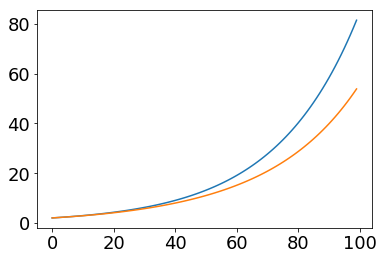

In [32]:
plt.plot(synaptic_expense(res_df.loc[1, 500, 'FS'].index.values, 1))
plt.plot(synaptic_expense(res_df.loc[0.0, 500, 'RS'].index.values, 0.0))

In [26]:
info_res = obtain_efficiency(res_df.loc[0.4, 500, 'FS'], B=0.4, method='blahut', s=0.5, eps=1e-2, verbose=True, max_iter=1000)

[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
[4.82569708e-21 1.70877025e-21 5.85507125e-22 1.93105936e-22
 6.17873274e-23 1.89371177e-23 5.62909982e-24 1.60710440e-24
 4.40478467e-25 1.15925484e-25]
min: -19.38682101249969, max: 2.279813737713799, accuracy: 7.829051758692917
[0.009 0.009 0.009 0.009 0.009 0.009 0.009 0.009 0.009 0.009]
[5.61790203e-21 1.98928853e-21 6.81626222e-22 2.24806948e-22
 7.19305721e-23 2.20459076e-23 6.55319445e-24 1.87093283e-24
 5.12789103e-25 1.34956256e-25]
min: -17.479006219834524, max: 0.8448315314034254, accuracy: 6.764319421558462
[0.0081 0.0081 0.0081 0.0081 0.0081 0.0081 0.0081 0.0081 0.0081 0.0081]
[6.54015838e-21 2.31585777e-21 7.93524598e-22 2.61712119e-22
 8.37389709e-23 2.56650484e-23 7.62899200e-24 2.17807234e-24
 5.96970530e-25 1.57111193e-25]
min: -15.781692453933864, max: 0.1796037397874333, accuracy: 6.059131421819155
[0.00729 0.00729 0.00729 0.00729 0.00729 0.00729 0.00729 0.00729 0.00729
 0.00729]
[7.61381588e-21 2.69603787e-21 9.2

[0.00016423 0.00016423 0.00016423 0.00016423 0.00016423 0.00016423
 0.00016423 0.00016423 0.00016423 0.00016423]
[1.81179952e-18 6.41554799e-19 2.19827625e-19 7.25012858e-20
 2.31979439e-20 7.10990768e-21 2.11343567e-21 6.03384534e-22
 1.65376869e-22 4.35240200e-23]
min: -2.193790108829799, max: -1.8629185822704972, accuracy: 0.5676360503827533
[0.00014781 0.00014781 0.00014781 0.00014781 0.00014781 0.00014781
 0.00014781 0.00014781 0.00014781 0.00014781]
[2.10923148e-18 7.46874897e-19 2.55915372e-19 8.44033751e-20
 2.70062074e-20 8.27709741e-21 2.46038539e-21 7.02438455e-22
 1.92525771e-22 5.06690901e-23]
min: -2.1706407945168293, max: -1.8651370163049483, accuracy: 0.5326885488968751
[0.00013303 0.00013303 0.00013303 0.00013303 0.00013303 0.00013303
 0.00013303 0.00013303 0.00013303 0.00013303]
[2.45549102e-18 8.69484746e-19 2.97927421e-19 9.82593571e-20
 3.14396501e-20 9.63589749e-21 2.86429169e-21 8.17753447e-22
 2.24131540e-22 5.89871224e-23]
min: -2.149885697257764, max: -1.86723

 2.99690673e-06 2.99690673e-06]
[5.84313754e-16 2.06904402e-16 7.08954301e-17 2.33820015e-17
 7.48144470e-18 2.29297827e-18 6.81592827e-19 1.94594317e-19
 5.33348091e-20 1.40366988e-20]
min: -1.9653442003304842, max: -1.902758803792444, accuracy: 0.12976982943828183
[2.69721606e-06 2.69721606e-06 2.69721606e-06 2.69721606e-06
 2.69721606e-06 2.69721606e-06 2.69721606e-06 2.69721606e-06
 2.69721606e-06 2.69721606e-06]
[6.80236939e-16 2.40870621e-16 8.25338959e-17 2.72204806e-17
 8.70962736e-18 2.66940238e-18 7.93485721e-19 2.26539666e-19
 6.20904560e-20 1.63410171e-20]
min: -1.9646694672153546, max: -1.9032855001672102, accuracy: 0.12733209971898937
[2.42749445e-06 2.42749445e-06 2.42749445e-06 2.42749445e-06
 2.42749445e-06 2.42749445e-06 2.42749445e-06 2.42749445e-06
 2.42749445e-06 2.42749445e-06]
[7.91907242e-16 2.80412866e-16 9.60829767e-17 3.16890991e-17
 1.01394332e-17 3.10762171e-18 9.23747381e-19 2.63729287e-19
 7.22834635e-20 1.90236212e-20]
min: -1.9640354297230387, max: -1.9

[4.69092946e-13 1.66105702e-13 5.69160352e-14 1.87715093e-14
 6.00625493e-15 1.84085160e-15 5.47197763e-16 1.56224724e-16
 4.28184163e-17 1.12689907e-17]
min: -1.9518723851421773, max: -1.9165500110175149, accuracy: 0.07339397995051292
[2.61568927e-08 2.61568927e-08 2.61568927e-08 2.61568927e-08
 2.61568927e-08 2.61568927e-08 2.61568927e-08 2.61568927e-08
 2.61568927e-08 2.61568927e-08]
[5.46099493e-13 1.93373843e-13 6.62594878e-14 2.18530875e-14
 6.99225882e-15 2.14305146e-15 6.37027539e-16 1.81871107e-16
 4.98476379e-17 1.31189486e-17]
min: -1.9517237866365262, max: -1.9166680555967472, accuracy: 0.07283621709508419
[2.35412035e-08 2.35412035e-08 2.35412035e-08 2.35412035e-08
 2.35412035e-08 2.35412035e-08 2.35412035e-08 2.35412035e-08
 2.35412035e-08 2.35412035e-08]
[6.35747198e-13 2.25118285e-13 7.71367622e-14 2.54405407e-14
 8.14012683e-15 2.49486113e-15 7.41604010e-16 2.11727676e-16
 5.80307986e-17 1.52726018e-17]
min: -1.9515783092185357, max: -1.9167946273304715, accuracy: 0.07

 2.86206076e-09 2.86206076e-09]
[1.32864784e-11 4.70515733e-12 1.61233531e-12 5.31792469e-13
 1.70162102e-13 5.21542203e-14 1.55033237e-14 4.42626155e-15
 1.21317438e-15 3.19287399e-16]
min: -1.94921280046371, max: -1.9167946273304715, accuracy: 0.067286943325944
[2.57585469e-09 2.57585469e-09 2.57585469e-09 2.57585469e-09
 2.57585469e-09 2.57585469e-09 2.57585469e-09 2.57585469e-09
 2.57585469e-09 2.57585469e-09]
[1.54668197e-11 5.47735233e-12 1.87696549e-12 6.19079297e-13
 1.98093062e-13 6.07152204e-14 1.80482200e-14 5.15285174e-15
 1.41232484e-15 3.71701036e-16]
min: -1.949117252970197, max: -1.9167946273304715, accuracy: 0.06708558811866232
[2.31826922e-09 2.31826922e-09 2.31826922e-09 2.31826922e-09
 2.31826922e-09 2.31826922e-09 2.31826922e-09 2.31826922e-09
 2.31826922e-09 2.31826922e-09]
[1.80048388e-11 6.37624417e-12 2.18502034e-12 7.20690916e-13
 2.30608150e-13 7.06813573e-14 2.10108350e-14 5.99870808e-15
 1.64416570e-15 4.32718500e-16]
min: -1.9490235208288875, max: -1.91679

[8.84467064e-11 8.84467059e-11 8.84467057e-11 8.84467056e-11
 8.84467056e-11 8.84467056e-11 8.84467056e-11 8.84467056e-11
 8.84467056e-11 8.84467056e-11]
[1.97487525e-09 7.01496416e-10 2.41000734e-10 7.96401366e-11
 2.55201193e-11 7.83050782e-12 2.32991302e-12 6.65664384e-13
 1.82551783e-13 4.80664757e-14]
min: -1.9468375960553124, max: -1.9167946273304715, accuracy: 0.06227595742040872
[7.96020359e-11 7.96020354e-11 7.96020352e-11 7.96020351e-11
 7.96020351e-11 7.96020351e-11 7.96020351e-11 7.96020351e-11
 7.96020351e-11 7.96020351e-11]
[2.29571327e-09 8.15701415e-10 2.80306109e-10 9.26461728e-11
 2.96920906e-11 9.11163470e-12 2.71136438e-12 7.74701623e-13
 2.12466463e-13 5.59457504e-14]
min: -1.946785545273589, max: -1.9167946273304715, accuracy: 0.06216596940360166
[7.16418325e-11 7.16418319e-11 7.16418317e-11 7.16418316e-11
 7.16418316e-11 7.16418316e-11 7.16418315e-11 7.16418315e-11
 7.16418315e-11 7.16418315e-11]
[2.66833500e-09 9.48401813e-10 3.25995279e-10 1.07769144e-10
 3.454

 8.70997421e-12 8.70997421e-12]
[5.15895655e-08 1.86117524e-08 6.48047082e-09 2.16343247e-09
 6.98799942e-10 2.15752274e-10 6.45427873e-11 1.85145142e-11
 5.09416415e-12 1.34493487e-12]
min: -1.9458776119632422, max: -1.9167946273304715, accuracy: 0.060245300821789326
[7.83897909e-12 7.83897761e-12 7.83897707e-12 7.83897688e-12
 7.83897682e-12 7.83897680e-12 7.83897679e-12 7.83897679e-12
 7.83897679e-12 7.83897679e-12]
[5.96093714e-08 2.15344040e-08 7.50715204e-09 2.50850432e-09
 8.10858143e-10 2.50495456e-10 7.49743024e-11 2.15150599e-11
 5.92159919e-12 1.56379240e-12]
min: -1.945841955427211, max: -1.9167946273304715, accuracy: 0.06016977041033497
[7.05508151e-12 7.05507997e-12 7.05507941e-12 7.05507921e-12
 7.05507914e-12 7.05507912e-12 7.05507911e-12 7.05507911e-12
 7.05507911e-12 7.05507911e-12]
[6.88420754e-08 2.49056987e-08 8.69351762e-09 2.90779175e-09
 9.40664951e-10 2.90776694e-10 8.70778306e-11 2.49985539e-11
 6.88266779e-12 1.81809547e-12]
min: -1.945806888918908, max: -1.9

[6.94768895e-13 6.94765616e-13 6.94764365e-13 6.94763903e-13
 6.94763741e-13 6.94763687e-13 6.94763669e-13 6.94763664e-13
 6.94763662e-13 6.94763662e-13]
[1.38176047e-06 5.26913701e-07 1.93171790e-07 6.72232974e-08
 2.24834745e-08 7.14541093e-09 2.19293044e-09 6.41729204e-10
 1.79529775e-10 4.80653902e-11]
min: -1.9451640577677245, max: -1.9167946273304715, accuracy: 0.058731646557816215
[6.25292677e-13 6.25289311e-13 6.25288022e-13 6.25287545e-13
 6.25287378e-13 6.25287322e-13 6.25287304e-13 6.25287298e-13
 6.25287296e-13 6.25287296e-13]
[1.56870808e-06 6.00155144e-07 2.20720682e-07 7.70146746e-08
 2.58184450e-08 8.22207464e-09 2.52797727e-09 7.40874742e-10
 2.07527952e-10 5.56214306e-11]
min: -1.9451398588077435, max: -1.9167946273304715, accuracy: 0.058680217741342675
[5.62764096e-13 5.62760642e-13 5.62759316e-13 5.62758824e-13
 5.62758652e-13 5.62758593e-13 5.62758574e-13 5.62758569e-13
 5.62758567e-13 5.62758566e-13]
[1.77927662e-06 6.82973752e-07 2.51992768e-07 8.81662099e-08
 2.

[5.54268747e-14 5.54220685e-14 5.54200829e-14 5.54192854e-14
 5.54189868e-14 5.54188794e-14 5.54188431e-14 5.54188312e-14
 5.54188276e-14 5.54188265e-14]
[2.21182566e-05 9.20367435e-06 3.68381609e-06 1.38471160e-06
 4.97199982e-07 1.68903894e-07 5.50832173e-08 1.69892719e-08
 4.97824444e-09 1.38893982e-09]
min: -1.9446736891421965, max: -1.9167946273304715, accuracy: 0.0576877510842946
[4.98850443e-14 4.98802182e-14 4.98782173e-14 4.98774105e-14
 4.98771074e-14 4.98769980e-14 4.98769609e-14 4.98769488e-14
 4.98769450e-14 4.98769439e-14]
[2.45137478e-05 1.02389521e-05 4.11403739e-06 1.55189982e-06
 5.59121692e-07 1.90575011e-07 6.23437864e-08 1.92831225e-08
 5.66505788e-09 1.58432257e-09]
min: -1.9446567929555358, max: -1.9167946273304715, accuracy: 0.05765170626880412
[4.48973947e-14 4.48925534e-14 4.48905390e-14 4.48897236e-14
 4.48894162e-14 4.48893048e-14 4.48892670e-14 4.48892546e-14
 4.48892507e-14 4.48892496e-14]
[2.71405705e-05 1.13787899e-05 4.58966071e-06 1.73744421e-06
 6.281

[5.46492607e-15 5.46071389e-15 5.45883552e-15 5.45801444e-15
 5.45768316e-15 5.45755511e-15 5.45750866e-15 5.45749241e-15
 5.45748707e-15 5.45748541e-15]
[1.66472691e-04 7.49368025e-05 3.24891889e-05 1.31649407e-05
 5.08973801e-06 1.86150409e-06 6.51113795e-07 2.14439294e-07
 6.69136681e-08 1.97983361e-08]
min: -1.9443514017038999, max: -1.9167946273304715, accuracy: 0.05699906101070826
[4.91906927e-15 4.91492849e-15 4.91307591e-15 4.91226321e-15
 4.91193426e-15 4.91180670e-15 4.91176027e-15 4.91174399e-15
 4.91173862e-15 4.91173695e-15]
[1.80195667e-04 8.13809323e-05 3.53990918e-05 1.43894043e-05
 5.58089730e-06 2.04763800e-06 7.18442805e-07 2.37310948e-07
 7.42706204e-08 2.20368464e-08]
min: -1.9443389137084495, max: -1.9167946273304715, accuracy: 0.05697232087474605
[4.42778182e-15 4.42371517e-15 4.42188987e-15 4.42108629e-15
 4.42075999e-15 4.42063306e-15 4.42058671e-15 4.42057040e-15
 4.42056501e-15 4.42056333e-15]
[1.94827310e-04 8.82757611e-05 3.85230953e-05 1.57082969e-05
 6.11

 6.76734916e-07 2.15027149e-07]
min: -1.944063947974162, max: -1.9167946273304715, accuracy: 0.05638225751557576
[2.88992797e-16 2.87196989e-16 2.86330213e-16 2.85917790e-16
 2.85738041e-16 2.85662777e-16 2.85633238e-16 2.85622044e-16
 2.85618093e-16 2.85616767e-16]
[9.67243767e-04 4.72065495e-04 2.21331658e-04 9.67774177e-05
 4.04574499e-05 1.59811026e-05 6.04307749e-06 2.14082194e-06
 7.21992473e-07 2.29958775e-07]
min: -1.9440550046947438, max: -1.9167946273304715, accuracy: 0.05636301976196963
[2.60288816e-16 2.58572014e-16 2.57741470e-16 2.57345344e-16
 2.57172314e-16 2.57099689e-16 2.57071120e-16 2.57060267e-16
 2.57056427e-16 2.57055136e-16]
[1.01106404e-03 4.94681640e-04 2.32465127e-04 1.01877406e-04
 4.26897173e-05 1.69021438e-05 6.40697269e-06 2.27481704e-06
 7.69109661e-07 2.45550411e-07]
min: -1.9440461642648224, max: -1.9167946273304715, accuracy: 0.05634400011790556
[2.34443802e-16 2.32804180e-16 2.32009184e-16 2.31629127e-16
 2.31462753e-16 2.31392756e-16 2.31365159e-16 

min: -1.9438541626398738, max: -1.9167946273304715, accuracy: 0.05593010467658073
[1.73530152e-17 1.69733753e-17 1.67809569e-17 1.66849266e-17
 1.66409855e-17 1.66215783e-17 1.66135550e-17 1.66103314e-17
 1.66091366e-17 1.66087113e-17]
[2.05173824e-03 1.06363974e-03 5.25135813e-04 2.42799708e-04
 1.07478041e-04 4.50054788e-05 1.80835910e-05 6.77563612e-06
 2.43540162e-06 8.23872719e-07]
min: -1.9438474874410758, max: -1.9167946273304715, accuracy: 0.05591568549167227
[1.56425843e-17 1.52886489e-17 1.51090169e-17 1.50192638e-17
 1.49781363e-17 1.49599430e-17 1.49524094e-17 1.49493769e-17
 1.49482512e-17 1.49478498e-17]
[2.07611163e-03 1.07846000e-03 5.33321098e-04 2.47067806e-04
 1.09586295e-04 4.59856202e-05 1.85173408e-05 6.95232995e-06
 2.50470277e-06 8.49163258e-07]
min: -1.9438408790333348, max: -1.9167946273304715, accuracy: 0.055901408545396686
[1.41010113e-17 1.37713015e-17 1.36037440e-17 1.35199295e-17
 1.34814693e-17 1.34644292e-17 1.34573618e-17 1.34545118e-17
 1.34534522e-17

 9.65882683e-19 9.65815164e-19]
[2.13681475e-03 1.16763368e-03 6.02063277e-04 2.94156364e-04
 1.37685949e-04 6.13191810e-05 2.62068054e-05 1.04256991e-05
 4.00490449e-06 1.44214549e-06]
min: -1.943689495981783, max: -1.9167946273304715, accuracy: 0.05557379468606787
[9.52240437e-19 9.11009002e-19 8.89491537e-19 8.78508791e-19
 8.73309041e-19 8.70924427e-19 8.69896746e-19 8.69464015e-19
 8.69297117e-19 8.69234620e-19]
[2.12202894e-03 1.16179008e-03 6.00061343e-04 2.93824962e-04
 1.37833294e-04 6.15391957e-05 2.63663887e-05 1.05150239e-05
 4.04997298e-06 1.46202516e-06]
min: -1.9436843577570468, max: -1.9167946273304715, accuracy: 0.0555626559504734
[8.58427697e-19 8.20647320e-19 8.00915170e-19 7.90838196e-19
 7.86062208e-19 7.83869418e-19 7.82923091e-19 7.82523999e-19
 7.82369864e-19 7.82312046e-19]
[2.10650785e-03 1.15551937e-03 5.97836626e-04 2.93385761e-04
 1.37931605e-04 6.17390837e-05 2.65184154e-05 1.06018951e-05
 4.09436453e-06 1.48177061e-06]
min: -1.9436792635937374, max: -1.91

[6.39160061e-20 6.01329347e-20 5.81230942e-20 5.70849109e-20
 5.65803155e-20 5.63424823e-20 5.62362956e-20 5.61897842e-20
 5.61711883e-20 5.61638990e-20]
[1.63017178e-03 9.40120527e-04 5.09605948e-04 2.65667987e-04
 1.32503384e-04 6.35034231e-05 2.91903067e-05 1.24775098e-05
 5.17158745e-06 2.00025835e-06]
min: -1.9435645852330627, max: -1.9167946273304715, accuracy: 0.05530267881398556
[5.75971693e-20 5.41591204e-20 5.23314698e-20 5.13870107e-20
 5.09275195e-20 5.07107328e-20 5.06138124e-20 5.05712954e-20
 5.05542723e-20 5.05475876e-20]
[1.61200073e-03 9.31601230e-04 5.06019168e-04 2.64486185e-04
 1.32244810e-04 6.35634456e-05 2.93023770e-05 1.25609031e-05
 5.22148355e-06 2.02515022e-06]
min: -1.9435604467580323, max: -1.9167946273304715, accuracy: 0.05529368520633706
[5.19022914e-20 4.87784432e-20 4.71168155e-20 4.62578010e-20
 4.58394708e-20 4.56419105e-20 4.55534669e-20 4.55146094e-20
 4.54990294e-20 4.54929003e-20]
[1.59411399e-03 9.23215715e-04 5.02495195e-04 2.63332687e-04
 1.31

 2.94009156e-21 2.93947965e-21]
[1.24836686e-03 7.66838776e-04 4.42233914e-04 2.48999380e-04
 1.33610980e-04 6.96347746e-05 3.48008242e-05 1.61357340e-05
 7.27140370e-06 3.04247335e-06]
min: -1.9434590902660676, max: -1.9167946273304715, accuracy: 0.05507323948517054
[3.10802771e-21 2.88648340e-21 2.76676482e-21 2.70419600e-21
 2.67289835e-21 2.65772857e-21 2.65068011e-21 2.64744754e-21
 2.64609733e-21 2.64553793e-21]
[1.23976322e-03 7.63397686e-04 4.41298511e-04 2.49188039e-04
 1.34074262e-04 7.00907857e-05 3.51358857e-05 1.63391896e-05
 7.38529390e-06 3.09887453e-06]
min: -1.9434556779401642, max: -1.9167946273304715, accuracy: 0.055065812743597675
[2.79991554e-21 2.59937373e-21 2.49094091e-21 2.43424694e-21
 2.40585875e-21 2.39208579e-21 2.38567713e-21 2.38273299e-21
 2.38150124e-21 2.38098986e-21]
[1.23148640e-03 7.60145466e-04 4.40470003e-04 2.49437851e-04
 1.34572724e-04 7.05675985e-05 3.54832130e-05 1.65494438e-05
 7.50288769e-06 3.15712854e-06]
min: -1.9434522873071254, max: -1

[1.85192642e-22 1.70472091e-22 1.62383268e-22 1.58105092e-22
 1.55900426e-22 1.54801893e-22 1.54269615e-22 1.54012848e-22
 1.53900244e-22 1.53850601e-22]
[1.11889200e-03 7.38173211e-04 4.56497993e-04 2.79086069e-04
 1.61768955e-04 9.19324567e-05 5.00674463e-05 2.52120177e-05
 1.23580746e-05 5.59496538e-06]
min: -1.943371008700126, max: -1.9167946273304715, accuracy: 0.05488147308663564
[1.66818055e-22 1.53512744e-22 1.46196698e-22 1.42325391e-22
 1.40327992e-22 1.39331640e-22 1.38848046e-22 1.38614274e-22
 1.38511547e-22 1.38466142e-22]
[1.11809061e-03 7.39617906e-04 4.58579346e-04 2.81197874e-04
 1.63449651e-04 9.31764011e-05 5.09009670e-05 2.57071239e-05
 1.26384358e-05 5.73791692e-06]
min: -1.943368121813682, max: -1.9167946273304715, accuracy: 0.05487518662780339
[1.50266479e-22 1.38240746e-22 1.31623839e-22 1.28120796e-22
 1.26311208e-22 1.25407541e-22 1.24968176e-22 1.24755335e-22
 1.24661615e-22 1.24620082e-22]
[1.11752560e-03 7.41226972e-04 4.60773041e-04 2.83389511e-04
 1.6518

 1.51598055e-23 1.51527024e-23]
[1.15368763e-03 8.08345420e-04 5.29794838e-04 3.46034846e-04
 2.13383991e-04 1.29829575e-04 7.56315964e-05 4.06108872e-05
 2.12490572e-05 1.02263387e-05]
min: -1.9433109728915572, max: -1.9167946273304715, accuracy: 0.054750745010953124
[1.67469662e-23 1.53169102e-23 1.45178724e-23 1.40902076e-23
 1.38630303e-23 1.37466975e-23 1.36878380e-23 1.36578783e-23
 1.36440498e-23 1.36375403e-23]
[1.15780815e-03 8.13504162e-04 5.34608277e-04 3.50233506e-04
 2.16584574e-04 1.32185494e-04 7.72390351e-05 4.15943409e-05
 2.18278615e-05 1.05338794e-05]
min: -1.9433084053287382, max: -1.9167946273304715, accuracy: 0.05474515485970291
[1.50858070e-23 1.37939187e-23 1.30715040e-23 1.26846323e-23
 1.24788235e-23 1.23732965e-23 1.23197924e-23 1.22924871e-23
 1.22798528e-23 1.22738866e-23]
[1.16214767e-03 8.18843421e-04 5.39564285e-04 3.54548219e-04
 2.19873715e-04 1.34608882e-04 7.88950188e-05 4.26092908e-05
 2.24264319e-05 1.08525836e-05]
min: -1.9433058507750705, max: -1

 2.76947823e-25 2.76665791e-25]
[1.47630950e-03 1.15328007e-03 8.38280336e-04 6.14018384e-04
 4.21713178e-04 2.88403657e-04 1.88443144e-04 1.12793956e-04
 6.59220119e-05 3.51794139e-05]
min: -1.9432216768218218, max: -1.9167946273304715, accuracy: 0.054556424475675
[3.17431044e-25 2.87501797e-25 2.70157506e-25 2.60645331e-25
 2.55241839e-25 2.52312026e-25 2.50681926e-25 2.49746599e-25
 2.49265787e-25 2.49006007e-25]
[1.49003001e-03 1.16740079e-03 8.50884291e-04 6.25129140e-04
 4.30564636e-04 2.95357337e-04 1.93564877e-04 1.16186348e-04
 6.81001394e-05 3.64393652e-05]
min: -1.9432195337251421, max: -1.9167946273304715, accuracy: 0.05455176426475208
[2.86018134e-25 2.58985925e-25 2.43302233e-25 2.34694546e-25
 2.29794376e-25 2.27132848e-25 2.25647608e-25 2.24792196e-25
 2.24351058e-25 2.24111741e-25]
[1.50406914e-03 1.18184719e-03 8.63790340e-04 6.36523530e-04
 4.39658897e-04 3.02517505e-04 1.98851037e-04 1.19695697e-04
 7.03588770e-05 3.77490074e-05]
min: -1.9432174001604454, max: -1.91

[2.35476149e-26 2.11972217e-26 1.97888849e-26 1.90015920e-26
 1.85262725e-26 1.82561766e-26 1.80930157e-26 1.79892028e-26
 1.79311831e-26 1.78962923e-26]
[1.95273491e-03 1.64676691e-03 1.28619072e-03 1.01855593e-03
 7.53102224e-04 5.57333509e-04 3.93426285e-04 2.53204989e-04
 1.59371846e-04 9.11358715e-05]
min: -1.9431688836650276, max: -1.9167946273304715, accuracy: 0.05444169558341769
[2.12249526e-26 1.91018672e-26 1.78277641e-26 1.71149435e-26
 1.66833849e-26 1.64376617e-26 1.62886833e-26 1.61934622e-26
 1.61400597e-26 1.61078016e-26]
[1.97689362e-03 1.67209150e-03 1.30959779e-03 1.04019848e-03
 7.71287003e-04 5.72515691e-04 4.05338671e-04 2.61593257e-04
 1.65117671e-04 9.46706362e-05]
min: -1.9431669676314174, max: -1.9167946273304715, accuracy: 0.05443753485478132
[1.91317483e-26 1.72139771e-26 1.60612858e-26 1.54158770e-26
 1.50240291e-26 1.48004650e-26 1.46644239e-26 1.45770731e-26
 1.45279141e-26 1.44980860e-26]
[2.00156630e-03 1.69799039e-03 1.33357666e-03 1.06241614e-03
 7.89

[1.95963485e-27 1.75468487e-27 1.62651086e-27 1.55349488e-27
 1.50594216e-27 1.47753025e-27 1.45866468e-27 1.44516358e-27
 1.43695843e-27 1.43145092e-27]
[0.00269849 0.00244436 0.00204077 0.00173594 0.00137373 0.00109253
 0.00082753 0.00056878 0.00038295 0.00023317]
min: -1.9431249955412848, max: -1.9167946273304715, accuracy: 0.054346459039597145
[1.76736268e-27 1.58221037e-27 1.46617683e-27 1.40002787e-27
 1.35679203e-27 1.33090405e-27 1.31364082e-27 1.30122101e-27
 1.29364671e-27 1.28853881e-27]
[0.00273845 0.00248799 0.00208298 0.00177711 0.00141028 0.00112495
 0.00085458 0.00058897 0.00039765 0.00024275]
min: -1.9431232572390609, max: -1.9167946273304715, accuracy: 0.05434269013327442
[1.59400484e-27 1.42673721e-27 1.32169100e-27 1.26176182e-27
 1.22244852e-27 1.19885876e-27 1.18306037e-27 1.17163388e-27
 1.16464113e-27 1.15990327e-27]
[0.00277925 0.00253263 0.00212627 0.00181943 0.00144795 0.00115844
 0.00088259 0.00060993 0.00041295 0.00025274]
min: -1.9431215257942662, max: -1.

 3.67546683e-29 3.63323419e-29]
[0.00474952 0.00477904 0.00439779 0.00414736 0.00362169 0.00319411
 0.002677   0.00202103 0.0014985  0.00099807]
min: -1.9430679926326615, max: -1.9167946273304715, accuracy: 0.05422301957117287
[4.88105708e-29 4.35311853e-29 3.98951360e-29 3.77895690e-29
 3.61804030e-29 3.51467133e-29 3.43317100e-29 3.36110435e-29
 3.31176458e-29 3.27244192e-29]
[0.00483368 0.00487838 0.00450169 0.00425775 0.00372852 0.00329795
 0.00277194 0.00209825 0.00156    0.00104166]
min: -1.9430664728935876, max: -1.9167946273304715, accuracy: 0.05421973329606952
[4.40941979e-29 3.93262970e-29 3.60309815e-29 3.41229207e-29
 3.26565234e-29 3.17129495e-29 3.09649652e-29 3.02991656e-29
 2.98419427e-29 2.94757708e-29]
[0.00491968 0.00498014 0.00460836 0.00437139 0.00383875 0.00340538
 0.00287043 0.00217854 0.0016241  0.00108722]
min: -1.9430649588173232, max: -1.9167946273304715, accuracy: 0.054216459534196036
[3.98361962e-29 3.55303724e-29 3.25437832e-29 3.08147465e-29
 2.94783735e-

 9.08975135e-31 8.74048686e-31]
[0.0093074  0.01043476 0.01060527 0.01109331 0.01070315 0.0104681
 0.00970714 0.00804437 0.00656691 0.00478316]
min: -1.943016656893702, max: -1.9167946273304715, accuracy: 0.05411217290744067
[1.32863407e-30 1.20083490e-30 1.09502135e-30 1.03780876e-30
 9.79420058e-31 9.40922506e-31 9.02195542e-31 8.56561125e-31
 8.22243938e-31 7.89561849e-31]
[0.009493   0.0106747  0.0108788  0.01141152 0.01104023 0.01082808
 0.01006847 0.0083648  0.00684627 0.00499871]
min: -1.9430153244165522, max: -1.9167946273304715, accuracy: 0.05410930056233032
[1.20457400e-30 1.08969841e-30 9.93833828e-31 9.42293958e-31
 8.89025246e-31 8.53941470e-31 8.18316183e-31 7.75905959e-31
 7.43948647e-31 7.13360420e-31]
[0.00968278 0.01092068 0.0111599  0.01173934 0.01138834 0.0112008
 0.01044353 0.00869816 0.00713763 0.00522403]
min: -1.943013996697733, max: -1.9167946273304715, accuracy: 0.054106438737451044
[1.09225748e-30 9.89034605e-31 9.02191709e-31 8.55785461e-31
 8.07189354e-31 7

 7.41312721e-32 6.73337795e-32]
[0.0157801  0.01910768 0.02082753 0.0233931  0.02419169 0.02539226
 0.02522105 0.02225644 0.01939449 0.0150095 ]
min: -1.942983504666263, max: -1.9167946273304715, accuracy: 0.054040791026934785
[1.09998002e-31 1.03703328e-31 9.61613109e-32 9.36811937e-32
 8.85555218e-32 8.56440933e-32 8.11848560e-32 7.36275300e-32
 6.77216156e-32 6.13057831e-32]
[0.01611238 0.0195671  0.02138451 0.0240818  0.02496834 0.0262755
 0.0261638  0.02314106 0.02021338 0.01567781]
min: -1.9429822892236777, max: -1.9167946273304715, accuracy: 0.05403817743385372
[1.00235199e-31 9.47492574e-32 8.79804182e-32 8.58876580e-32
 8.12431963e-32 7.86503097e-32 7.45488889e-32 6.74539578e-32
 6.19048660e-32 5.58460327e-32]
[0.01645221 0.02003816 0.02195689 0.02479107 0.02577002 0.02718921
 0.02714116 0.02405997 0.02106581 0.01637485]
min: -1.9429810780208083, max: -1.9167946273304715, accuracy: 0.054035573213817606
[9.13626606e-32 8.65994584e-32 8.05306585e-32 7.87849987e-32
 7.45801304e-3

 9.37522012e-33 7.44575682e-33]
[0.02737082 0.03568965 0.0415459  0.04971198 0.05478052 0.06117631
 0.06445856 0.05999285 0.05528734 0.04506077]
min: -1.9429532354090338, max: -1.9167946273304715, accuracy: 0.053975782658627486
[1.08677407e-32 1.14444797e-32 1.13820913e-32 1.22443500e-32
 1.21831480e-32 1.25947235e-32 1.22298094e-32 1.03070146e-32
 8.79945690e-33 6.93534472e-33]
[0.02796442 0.0365637  0.04266469 0.05116092 0.05650349 0.06323188
 0.06675292 0.06223464 0.05745788 0.04690836]
min: -1.9429521245692642, max: -1.9167946273304715, accuracy: 0.05397340028551406
[9.99307441e-33 1.05920820e-32 1.05828060e-32 1.14571204e-32
 1.14452810e-32 1.18910736e-32 1.15766008e-32 9.72400221e-33
 8.27238295e-33 6.46886457e-33]
[0.02857123 0.03745918 0.04381297 0.05264987 0.058277   0.06535045
 0.06912017 0.06454984 0.05970209 0.04882074]
min: -1.942951017530866, max: -1.9167946273304715, accuracy: 0.05397102631344632
[9.19303562e-33 9.80979142e-33 9.84812992e-33 1.07324100e-32
 1.07662689e-3

 3.53748896e-33 2.13780291e-33]
[0.04682403 0.06510203 0.0799489  0.09989425 0.11549527 0.13429323
 0.14653716 0.14052202 0.13383831 0.11238473]
min: -1.942926570184135, max: -1.9167946273304715, accuracy: 0.05391866671620328
[1.57109621e-33 2.10862424e-33 2.52472773e-33 3.49160979e-33
 4.15828497e-33 5.35087916e-33 5.93669259e-33 4.55869537e-33
 3.51416746e-33 2.09170037e-33]
[0.04783362 0.06666029 0.08201059 0.10258776 0.11878568 0.1382541
 0.15096186 0.1448365  0.13803516 0.11597116]
min: -1.9429255499135825, max: -1.9167946273304715, accuracy: 0.05391648445246301
[1.46643545e-33 1.99586123e-33 2.41676052e-33 3.39243806e-33
 4.08718592e-33 5.33209256e-33 5.96850109e-33 4.56363238e-33
 3.50129246e-33 2.05182744e-33]
[0.04886354 0.06825213 0.08411812 0.10533884 0.12214721 0.14229681
 0.15547141 0.14922676 0.14230043 0.11961159]
min: -1.942924533081008, max: -1.9167946273304715, accuracy: 0.05391430978246575
[1.36980083e-33 1.89134570e-33 2.31696499e-33 3.30259634e-33
 4.02689094e-33 5

[3.64918538e-34 7.98570765e-34 1.43281491e-33 3.30235228e-33
 5.99521335e-33 1.23893399e-32 1.84939173e-32 1.22368930e-32
 8.05328832e-33 2.83911474e-33]
[0.07914122 0.11537209 0.14630876 0.18431317 0.21770619 0.25375579
 0.27510375 0.26095054 0.24692556 0.20571803]
min: -1.942901126327394, max: -1.9167946273304715, accuracy: 0.053864319840685314
[3.48581937e-34 7.83012621e-34 1.43583534e-33 3.39690224e-33
 6.30658010e-33 1.33444923e-32 2.01952341e-32 1.32417362e-32
 8.63576592e-33 2.96281332e-33]
[0.08048264 0.11742128 0.14894396 0.18748746 0.22142188 0.25782586
 0.27916626 0.26442786 0.24990737 0.20795076]
min: -1.9429001912217063, max: -1.9167946273304715, accuracy: 0.053862325622085525
[3.33303004e-34 7.68877332e-34 1.44150263e-33 3.50168408e-33
 6.65047102e-33 1.44111844e-32 2.21103146e-32 1.43612257e-32
 9.27834244e-33 3.09651767e-33]
[0.08179976 0.11942062 0.15149818 0.19053588 0.22496426 0.26166145
 0.28294751 0.26761177 0.25258818 0.20991618]
min: -1.9428992592237109, max: -1.

[1.38595187e-34 6.77195735e-34 2.31427867e-33 1.10346612e-32
 3.72626118e-32 1.40131113e-31 2.81693221e-31 1.28982397e-31
 6.00444111e-32 9.29812968e-33]
[0.10451241 0.14900829 0.18358735 0.22121001 0.25319681 0.28128997
 0.29219788 0.26402326 0.23903621 0.1912189 ]
min: -1.9428769355341318, max: -1.9167946273304715, accuracy: 0.053812808295090726
[1.34844366e-34 6.79897435e-34 2.37935964e-33 1.16346985e-32
 4.01206678e-32 1.53626574e-31 3.10966315e-31 1.39849925e-31
 6.40564588e-32 9.60912772e-33]
[0.10528987 0.14988006 0.18435701 0.2217033  0.25336197 0.2809051
 0.2913355  0.26276214 0.23749479 0.18970082]
min: -1.9428760803311107, max: -1.9167946273304715, accuracy: 0.05381099034879705
[1.31268209e-34 6.83023495e-34 2.44754854e-33 1.22713681e-32
 4.32025563e-32 1.68380440e-31 3.43094215e-31 1.51510004e-31
 6.82676676e-32 9.92034654e-33]
[0.10607565 0.15076055 0.1851347  0.22220469 0.2535361  0.28053237
 0.29049018 0.26152225 0.23597899 0.18820888]
min: -1.9428752279342938, max: -1.9

[7.82318551e-35 1.07105265e-33 7.49653076e-33 7.26781038e-32
 4.31433309e-31 2.44582586e-30 5.34273186e-30 1.21712332e-30
 3.09096393e-31 1.72062111e-32]
[0.13293283 0.18039012 0.21121583 0.23963809 0.26123317 0.27277588
 0.27007036 0.23081621 0.19860637 0.15185673]
min: -1.9428509106703689, max: -1.9167946273304715, accuracy: 0.053757590985594836
[7.76661181e-35 1.09877897e-33 7.85185884e-33 7.75645252e-32
 4.66942032e-31 2.66682891e-30 5.81540978e-30 1.29146194e-30
 3.21027318e-31 1.73090127e-32]
[0.13370866 0.18116261 0.21179823 0.23986504 0.26108721 0.27212113
 0.26903369 0.22955435 0.19722325 0.15059853]
min: -1.9428501403009975, max: -1.9167946273304715, accuracy: 0.05375595996971713
[7.71465164e-35 1.12781528e-33 8.22721950e-33 8.27917537e-32
 5.05325643e-31 2.90658271e-30 6.32569811e-30 1.36920355e-30
 3.33108872e-31 1.73972290e-32]
[0.13443671 0.18186685 0.21230047 0.24000171 0.2608427  0.27136845
 0.267904   0.22821979 0.19578327 0.14930137]
min: -1.9428493724250346, max: -1.

 5.53244657e-31 1.41303249e-32]
[0.13307318 0.17371445 0.19680822 0.21448209 0.2254148  0.22618641
 0.21675753 0.17905668 0.14915673 0.11087169]
min: -1.9428316683355904, max: -1.9167946273304715, accuracy: 0.05371691734414149
[6.80859528e-35 2.15303636e-33 2.47109265e-32 3.61679875e-31
 2.85626427e-30 1.78458776e-29 3.46600567e-29 3.90614714e-30
 5.55506590e-31 1.38105755e-32]
[0.13266567 0.17296971 0.19579328 0.21313323 0.22374408 0.22426725
 0.21472177 0.17722047 0.14750036 0.10956087]
min: -1.942830959935316, max: -1.9167946273304715, accuracy: 0.0537154226913987
[6.75807680e-35 2.19761756e-33 2.56161751e-32 3.79306037e-31
 3.01661177e-30 1.88542407e-29 3.63876076e-29 3.99861570e-30
 5.57135624e-31 1.34854277e-32]
[0.13227266 0.17225038 0.19481433 0.21183276 0.22213355 0.22241913
 0.21276334 0.17545602 0.14591042 0.10830393]
min: -1.942830253803873, max: -1.9167946273304715, accuracy: 0.05371393302772257
[6.70607926e-35 2.24201852e-33 2.65370839e-32 3.97446925e-31
 3.18257031e-30 1

 4.81199437e-31 6.73168000e-33]
[0.12838174 0.16376465 0.18278868 0.19507073 0.20070514 0.19748224
 0.18622079 0.15150285 0.12433345 0.09129624]
min: -1.942815276738836, max: -1.9167946273304715, accuracy: 0.05368238653693644
[5.41953668e-35 3.20172682e-33 5.14762360e-32 9.52083310e-31
 8.52354826e-30 5.19244626e-29 8.51803312e-29 5.34707679e-30
 4.74830401e-31 6.48738544e-33]
[0.12840007 0.16366485 0.18259855 0.19473628 0.20022198 0.19688446
 0.18556657 0.1509007  0.12378408 0.09086113]
min: -1.9428146206012629, max: -1.9167946273304715, accuracy: 0.05368100673621595
[5.36318443e-35 3.24722656e-33 5.28878992e-32 9.86257121e-31
 8.86211920e-30 5.38660634e-29 8.76927065e-29 5.37543627e-30
 4.68363599e-31 6.24998634e-33]
[0.12843176 0.16358384 0.18243121 0.19442837 0.19976857 0.19631842
 0.18494453 0.15032647 0.12325912 0.09044493]
min: -1.942813966545267, max: -1.9167946273304715, accuracy: 0.05367963150666329
[5.30753640e-35 3.29318908e-33 5.43320950e-32 1.02144555e-30
 9.21133398e-30 

[4.27616558e-35 4.58790222e-33 1.00620677e-31 2.23005910e-30
 2.13337907e-29 1.20323998e-28 1.61141435e-28 5.59630646e-30
 3.10395879e-31 2.38790538e-33]
[0.132268   0.1658292  0.18340617 0.19272023 0.19514184 0.18930811
 0.1766093  0.1422132  0.11557613 0.0842396 ]
min: -1.9427988748029152, max: -1.9167946273304715, accuracy: 0.05364795522429648
[4.24323806e-35 4.66002204e-33 1.03436565e-31 2.30696216e-30
 2.21055324e-29 1.24186843e-28 1.64886711e-28 5.59205190e-30
 3.04390269e-31 2.28948642e-33]
[0.13252672 0.16605206 0.18359736 0.19281561 0.1951281  0.18920054
 0.17644451 0.14203025 0.11538919 0.08408274]
min: -1.9427982704477447, max: -1.9167946273304715, accuracy: 0.05364668905386306
[4.21132995e-35 4.73399993e-33 1.06345050e-31 2.38667055e-30
 2.29049780e-29 1.28164369e-28 1.68700063e-28 5.58708633e-30
 2.98461133e-31 2.19487317e-33]
[0.13279164 0.16628261 0.18379725 0.19292023 0.19512398 0.1891026
 0.17628906 0.14185512 0.11520886 0.08393088]
min: -1.9427976679902723, max: -1.91

[3.74909345e-35 1.00553409e-32 3.51274320e-31 9.52691452e-30
 9.18750234e-29 4.20832836e-28 3.86262129e-28 5.09388821e-30
 1.32046820e-31 4.15262016e-34]
[0.14649934 0.17923473 0.19592246 0.20141728 0.19940985 0.18962247
 0.17435549 0.13843273 0.11103119 0.08014388]
min: -1.9427761167682407, max: -1.9167946273304715, accuracy: 0.05360041082568943
[3.75744804e-35 1.03074428e-32 3.64171806e-31 9.91323673e-30
 9.54719129e-29 4.34434195e-28 3.94631146e-28 5.07656635e-30
 1.29072923e-31 3.96959362e-34]
[0.14694022 0.17965985 0.1963273  0.20171881 0.19959234 0.18969697
 0.17435772 0.13838343 0.11095328 0.08006698]
min: -1.9427755833296048, max: -1.9167946273304715, accuracy: 0.05359929994163885
[3.76697703e-35 1.05689224e-32 3.77645694e-31 1.03173097e-29
 9.92217710e-29 4.48497703e-28 4.03182078e-28 5.05912848e-30
 1.26158980e-31 3.79442086e-34]
[0.14738474 0.18008843 0.19673542 0.20202294 0.1997768  0.18977284
 0.17436092 0.13833472 0.11087573 0.07999028]
min: -1.942775051539121, max: -1.91

[4.32502624e-35 1.98173378e-32 9.03315195e-31 2.62291217e-29
 2.39367018e-28 9.16765361e-28 6.46875568e-28 4.65112951e-30
 7.52789628e-32 1.38594342e-34]
[0.15805353 0.19032216 0.20644268 0.20924277 0.2041848  0.19163901
 0.17452683 0.13728755 0.1091548  0.07827192]
min: -1.9427637576721357, max: -1.9167946273304715, accuracy: 0.05357471864344672
[4.36952940e-35 2.04674797e-32 9.43111305e-31 2.74359110e-29
 2.49535346e-28 9.47683843e-28 6.60967591e-28 4.63159103e-30
 7.34849277e-32 1.32304669e-34]
[0.15857793 0.19082125 0.20691324 0.20959007 0.20439543 0.19172686
 0.17453289 0.13723624 0.10907191 0.07818945]
min: -1.9427632622384583, max: -1.9167946273304715, accuracy: 0.053573690786223975
[4.41608919e-35 2.11460775e-32 9.84970269e-31 2.87048711e-29
 2.60172284e-28 9.79703101e-28 6.75369362e-28 4.61196858e-30
 7.17293944e-32 1.26292816e-34]
[0.15910571 0.1913231  0.20738607 0.20993866 0.20460652 0.19181452
 0.1745384  0.13718426 0.10898832 0.07810639]
min: -1.9427627683201323, max: -1.

 0.17436903 0.13556658 0.10659512 0.07578315]
min: -1.9427508977317838, max: -1.9167946273304715, accuracy: 0.05354809361055355
[6.65260865e-35 5.58802488e-32 3.41605369e-30 1.01088268e-28
 8.09538239e-28 2.37069501e-27 1.18235270e-27 4.06975368e-30
 3.73890390e-32 3.68408840e-35]
[0.17399802 0.20526982 0.22037216 0.21932196 0.21011091 0.19388193
 0.17434542 0.13548561 0.10648453 0.07567848]
min: -1.9427504414134846, max: -1.9167946273304715, accuracy: 0.05354715103498553
[6.79506861e-35 5.82962489e-32 3.59974714e-30 1.06450066e-28
 8.47273554e-28 2.45435435e-27 1.20795839e-27 4.04753512e-30
 3.64282860e-32 3.51022784e-35]
[0.17461531 0.20583824 0.22089443 0.21969025 0.21031786 0.193948
 0.17432018 0.13540316 0.10637262 0.07557277]
min: -1.9427499864744555, max: -1.9167946273304715, accuracy: 0.05354621146304909
[6.94350576e-35 6.08398243e-32 3.79463007e-30 1.12123608e-28
 8.86890133e-28 2.54107895e-27 1.23409728e-27 4.02520479e-30
 3.54893747e-32 3.34431317e-35]
[0.17523586 0.20640884

 2.00959262e-32 1.18663677e-35]
[0.18900673 0.21884983 0.23267632 0.22776514 0.21460718 0.19498514
 0.17328463 0.13315956 0.10353826 0.07296368]
min: -1.942740317262058, max: -1.9167946273304715, accuracy: 0.05352627958772678
[1.24776126e-34 1.71814030e-31 1.32281392e-29 3.73727096e-28
 2.50643690e-27 5.50489967e-27 1.96285577e-27 3.50383486e-30
 1.95382096e-32 1.12838815e-35]
[0.18969688 0.21946175 0.23322164 0.22812688 0.21478609 0.19500967
 0.17321257 0.13303581 0.10339093 0.07283122]
min: -1.94273989275915, max: -1.9167946273304715, accuracy: 0.053525406228354104
[1.28814790e-34 1.80943662e-31 1.40580479e-29 3.95845421e-28
 2.63144321e-27 5.70348594e-27 2.00381038e-27 3.47871289e-30
 1.89939621e-32 1.07289447e-35]
[0.19039006 0.22007521 0.23376748 0.22848778 0.21496323 0.1950319
 0.17313805 0.13290998 0.10324187 0.07269746]
min: -1.942739469525247, max: -1.9167946273304715, accuracy: 0.053524535626674676
[1.33046474e-34 1.90635857e-31 1.49453769e-29 4.19372435e-28
 2.76300921e-27 5

 9.90620281e-33 3.44482370e-36]
[0.20636526 0.23387679 0.24580201 0.23610313 0.2183069  0.1948494
 0.17080464 0.12956355 0.09948896 0.06940948]
min: -1.9427304707154092, max: -1.9167946273304715, accuracy: 0.053506060637997566
[3.06065865e-34 6.66798854e-31 6.29035345e-29 1.58349911e-27
 8.30277128e-27 1.28942889e-26 3.16520827e-27 2.86776266e-30
 9.60328178e-33 3.26718212e-36]
[0.2071219  0.23451364 0.2463448  0.23642888 0.21842849 0.19480619
 0.17066348 0.12938281 0.09929532 0.06924344]
min: -1.942730075487997, max: -1.9167946273304715, accuracy: 0.05350525083091351
[3.19693377e-34 7.09232651e-31 6.74258950e-29 1.68638616e-27
 8.73795471e-27 1.33575956e-26 3.22561610e-27 2.83988877e-30
 9.30832592e-33 3.09832251e-36]
[0.20788092 0.23515087 0.24688668 0.23675231 0.21854693 0.19475953
 0.17051895 0.12919936 0.09909954 0.06907588]
min: -1.942729681428436, max: -1.9167946273304715, accuracy: 0.053504443556006476
[3.34096951e-34 7.54682163e-31 7.22988741e-29 1.79633871e-27
 9.19666960e-27

C:\Users\Administrator\iCloudDrive\Documents\PhD\projects\MAT capacity\coding\optimization\blahut_arimoto.py:59: RuntimeWarning: Maximum number of iterations (1000) reached
  warnings.warn(f'Maximum number of iterations ({max_iter}) reached', RuntimeWarning)


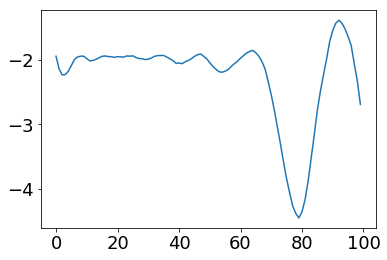

In [34]:
plt.plot(info_res['sensitivity'] - 0.5 * expenses)

In [35]:
from cvxopt import solvers

In [36]:
?solvers.lp

In [18]:
pdf = jimbo_opt(info_res['rates'], eps=1e-2)['pdf']

In [39]:
tmp = jimbo_opt(info_res['rates'], eps=1e-2)
tmp['fun'] / tmp['expense']

0.20219613353288368

(0, 0.1)

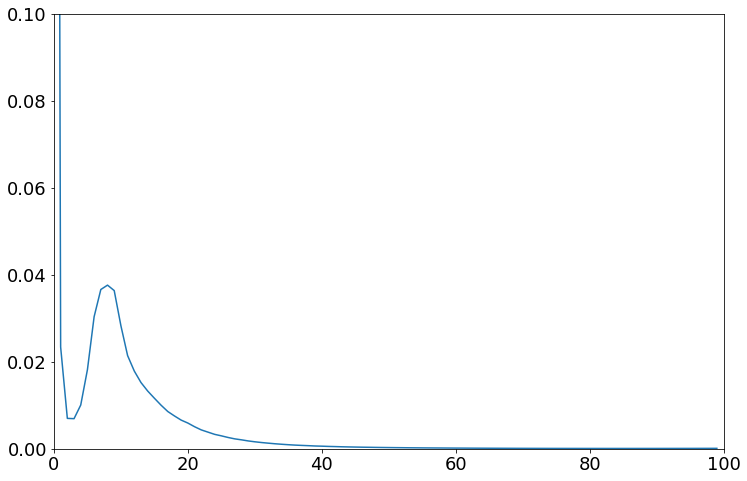

In [40]:
plt.figure(figsize=(12,8))
plt.plot(tmp['pdf'])
plt.xlim(0,100)
plt.ylim(0,0.1)

In [31]:
rates = info_res['rates']

In [32]:
syn_expenses = synaptic_expense(res_df.loc[0.4, 500, 'FS'].index.values, B=0.4)
expenses = rates.dot(np.arange(rates.shape[1])) * 0.71 + 0.32 + syn_expenses

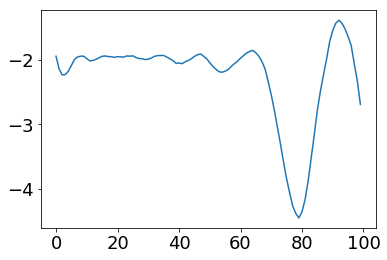

In [66]:
plt.plot(info_res['sensitivity'] - 0.5 * expenses)

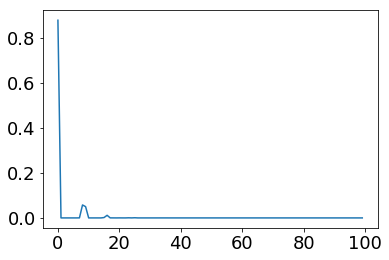

In [64]:
plt.plot(info_res['pdf'])

In [51]:
np.log(np.exp(info_res['sensitivity'] - 0.5 * expenses)).dot(info_res['pdf'])

-1.9425161836961145

In [52]:
(info_res['sensitivity'] - 0.5 * expenses).max()

3.815689083555

In [37]:
(info_res['sensitivity'] - 0.5 * expenses).dot(info_res['pdf'])

-2.4593274545456785

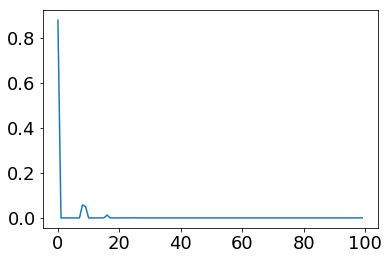

In [54]:
plt.plot(info_res['pdf'])

In [55]:
info_res['pdf'][-1]

0.0

In [63]:
pdf = info_res['pdf']
pdf.dot(np.arange(pdf.shape[0]))

38.84681335642302

In [41]:
%%time
info_res = obtain_efficiency(res_df.loc[0.4, 500, 'FS'], B=0.4, method='jimbo', eps=1e-4)

Wall time: 619 ms


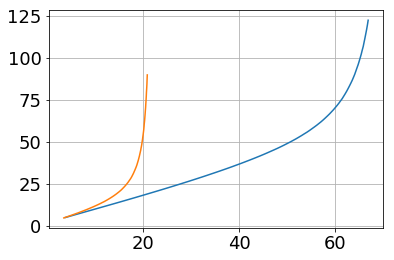

In [31]:
info_res = obtain_efficiency(res_df.loc[0.4, 500, 'FS'], B=0.4)
rates = info_res['rates']
psfr = rates.dot(np.arange(rates.shape[1]))
expenses = psfr * 0.71 + synaptic_expense(res_df.loc[0.4, 500, 'FS'].index.values, 0.4)
plt.plot(psfr, expenses)

info_res = obtain_efficiency(res_df.loc[0.4, 500, 'RS'], B=0.4)
rates = info_res['rates']
psfr = rates.dot(np.arange(rates.shape[1]))
expenses = psfr * 0.71 + synaptic_expense(res_df.loc[0.4, 500, 'RS'].index.values, 0.4)
plt.plot(psfr, expenses)

plt.grid()

In [16]:
info_res['pdf'].sum()

1.0000000000000004

In [15]:
info_res['rates'].sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

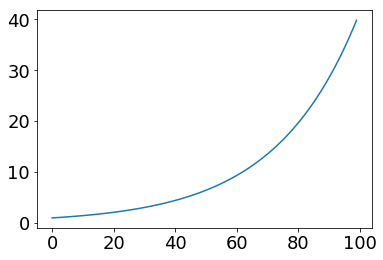

In [30]:
plt.plot(list(res_df.loc[0.4, 500, 'FS'].index)

C:\Users\Administrator\iCloudDrive\Documents\PhD\projects\MAT capacity\coding\optimization\__init__.py:7: RuntimeWarning: invalid value encountered in true_divide
  specificity = sr_grid / prior


In [6]:
info_res['fun'] / info_res['expense']

0.18609077430562768

In [7]:
info_res['expense']

8.65510568896535

In [1]:
info_res

NameError: name 'info_res' is not defined

In [12]:
info_res['rates'].T.dot(info_res['pdf'])

array([2.85132444e-10, 5.15440384e-03, 5.71997406e-02, 1.53550223e-01,
       1.80324168e-01, 1.04548499e-01, 7.03644487e-02, 7.89990301e-02,
       7.00892798e-02, 5.37265291e-02, 4.79237036e-02, 4.14676954e-02,
       3.49906149e-02, 2.98904712e-02, 2.30562071e-02, 1.80692435e-02,
       1.35840424e-02, 8.92763486e-03, 5.15875152e-03, 2.28547041e-03,
       6.14698322e-04, 7.33204345e-05, 1.82139098e-06, 2.81078182e-09,
       0.00000000e+00])

In [8]:
synaptic_expense(res_df.loc[0.4, 500, 'FS'].index.values, 0.4)

array([ 2.09729811,  2.17337701,  2.25218331,  2.33381576,  2.41837688,
        2.50597311,  2.59671497,  2.69071724,  2.78809913,  2.88898446,
        2.99350182,  3.10178482,  3.21397222,  3.33020821,  3.45064255,
        3.57543086,  3.70473482,  3.83872239,  3.97756811,  4.12145331,
        4.27056639,  4.42510309,  4.5852668 ,  4.75126882,  4.9233287 ,
        5.1016745 ,  5.28654319,  5.47818093,  5.67684345,  5.8827964 ,
        6.09631574,  6.31768811,  6.54721124,  6.78519438,  7.03195872,
        7.28783786,  7.55317821,  7.82833958,  8.11369558,  8.40963418,
        8.71655827,  9.03488617,  9.36505225,  9.70750749, 10.06272013,
       10.43117633, 10.81338079, 11.2098575 , 11.62115043, 12.04782426,
       12.49046523, 12.94968187, 13.42610586, 13.92039294, 14.43322375,
       14.96530482, 15.51736949, 16.090179  , 16.68452343, 17.30122289,
       17.94112858, 18.60512401, 19.29412619, 20.0090869 , 20.750994  ,
       21.52087281, 22.3197875 , 23.14884257, 24.0091844 , 24.90

In [34]:
for neuron in ['RS','FS','IB','CH']:
    print(neuron)
    for B in [0, 0.2, 0.4, 0.6, 0.8, 1]:
        info_res = obtain_efficiency(res_df.loc[B, 250, neuron], B=B)
        print(info_res['fun'] / info_res['expense'])

RS
0.21367395092492122
0.20279439021770654
0.18712451662728075
0.16240341112711978
0.12870694483431533
0.07838028726444286
FS
0.22509985723407863
0.22141852698669628
0.21563552135727898
0.2030613001516431
0.17592187732258513
0.12354919587797403
IB
0.2030417960999145
0.19615019995511382
0.18593272162697647
0.1668540445267127
0.1351173143986623
0.08530039981807537
CH
0.1463811548501799
0.14403656777275858
0.1428526300817128
0.1370688997236516
0.11892027592490848
0.06830192567890228


In [23]:
res_df.loc[0.4, 500, 'RS']

1.000000     [[0.0, 0.0, 0.01375, 0.19, 0.48625, 0.2725, 0....
1.037915     [[0.0, 0.0, 0.0175, 0.20875, 0.485, 0.265, 0.0...
1.077267     [[0.0, 0.0, 0.0225, 0.2075, 0.52125, 0.225, 0....
1.118111     [[0.0, 0.0, 0.02125, 0.2625, 0.4875, 0.20625, ...
1.160504     [[0.0, 0.0, 0.0225, 0.28625, 0.48625, 0.19, 0....
1.204504     [[0.0, 0.0, 0.03125, 0.31, 0.47125, 0.17625, 0...
1.250172     [[0.0, 0.0, 0.0375, 0.32125, 0.475, 0.155, 0.0...
1.297572     [[0.0, 0.00125, 0.0375, 0.35875, 0.44375, 0.15...
1.346768     [[0.0, 0.0, 0.05375, 0.38625, 0.42125, 0.12875...
1.397831     [[0.0, 0.0, 0.055, 0.40875, 0.425, 0.10375, 0....
1.450829     [[0.0, 0.0, 0.0825, 0.4075, 0.4025, 0.10125, 0...
1.505836     [[0.0, 0.005, 0.095, 0.42625, 0.38875, 0.08, 0...
1.562930     [[0.0, 0.00625, 0.09875, 0.45625, 0.37125, 0.0...
1.622187     [[0.0, 0.00625, 0.105, 0.48625, 0.3375, 0.0637...
1.683692     [[0.0, 0.0075, 0.125, 0.49, 0.31875, 0.0575, 0...
1.747528     [[0.0, 0.00625, 0.1425, 0.48875, 0.3175, 0

In [69]:
import matplotlib.gridspec as gridspec

In [52]:
from scipy.interpolate import UnivariateSpline

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


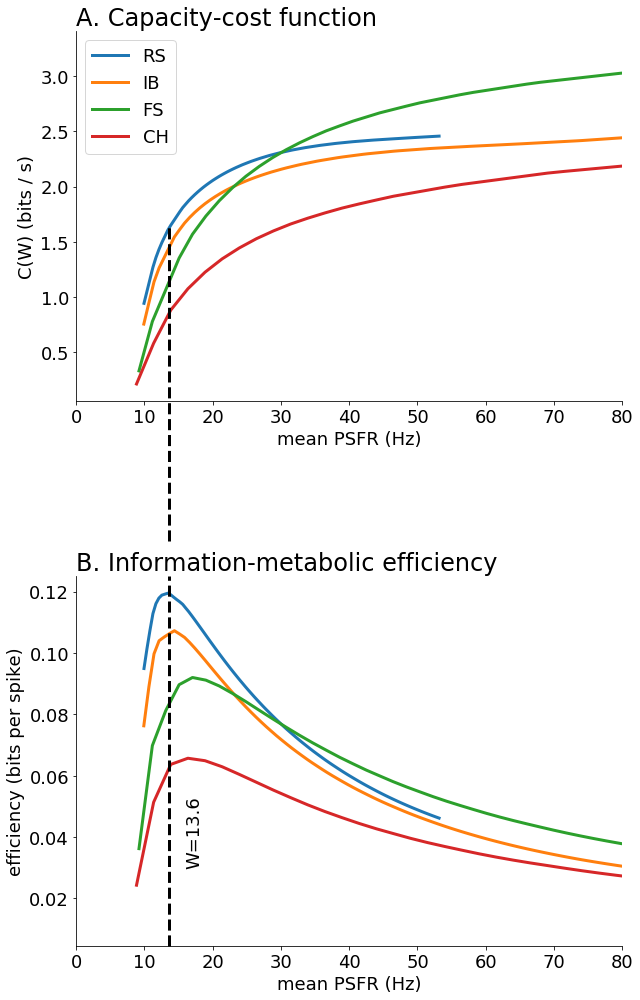

In [71]:

cost_capacities = pd.Series({neuron: get_cost_capacity(neuron) for neuron in neurons})
fig, axes = plt.subplots(tight_layout=True, figsize=(9,14), nrows=2)

# CAPACITY-COST

ax1 = axes[0]
ax2 = axes[1]

for i, neuron in enumerate(neurons):
    cost_capacities[neuron]['W'] = cost_capacities[neuron]['W'] * 1000 / tw
    ser = cost_capacities[neuron].set_index('W').sort_index()
    x = ser.index.get_level_values(0).values
    y = ser['C'].values
    f = UnivariateSpline(x, y, s=0, k=1)
    x_arr = np.linspace(x.min(),x.max(), 100)
    ax1.plot(x_arr, f(x_arr), lw=3, label=neuron)
    ax2.plot(x_arr, f(x_arr) / x_arr, lw=3)
#     cost_capacities[neuron].set_index('W').sort_index()['C'].plot(ax=ax1, c=f'C{i}', lw=3, label=neuron)
#     cost_capacities[neuron].set_index('W').sort_index()['C/W'].plot(ax=ax2, c=f'C{i}', lw=3)
    
#     maxloc = cost_capacities[neuron]['C/W'].argmax()
#     best = cost_capacities[neuron].loc[maxloc]
#     axes[0].axvline(best['W'], c=f'C{i}')

ax1.legend()
ax1.set_xlim(0,40 * 1000 / tw)
ax2.set_xlim(0,40 * 1000 / tw)
# axes[0].grid()
# axes[1].grid()
ax1.set_xlabel('mean PSFR (Hz)')
ax2.set_xlabel('mean PSFR (Hz)')

ax1.set_title('A. Capacity-cost function', loc='left', fontsize=24)
ax1.set_ylabel('C(W) (bits / s)')

ax2.set_title('B. Information-metabolic efficiency', loc='left', fontsize=24)
ax2.set_ylabel('efficiency (bits per spike)')

for side in ['right','top']:
    ax1.spines[side].set_visible(False)
    ax2.spines[side].set_visible(False)

# RS cara
c, cw, w = cost_capacities['RS'].sort_values('C/W').iloc[-1]
ylims = ax1.get_ylim()
ax1.axvline(w, -0.38, c / ylims[1], lw=3, linestyle='dashed', clip_on=False, c='black')
ax2.axvline(w, 0, 1, lw=3, linestyle='dashed', clip_on=False, c='black')
ax2.text(x=16, y=0.03, s=f'W={w:.1f}', rotation=90, fontsize=18, va='bottom')
# ax2.axvline(20, 0, 2, clip_on=False)


plt.savefig(f'{publication_directory}/img/cost_capacity.pdf', bbox_inches='tight')